In [1]:
import torch
import numpy as np
import pandas as pd
import os
import sys

In [2]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch import optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap

In [3]:
from scipy import stats

In [4]:
import matplotlib.pyplot as plt

In [5]:
## Read Data

In [6]:
from pickle import dump

In [39]:
data = pd.read_csv('../data/gesture-recognition-and-biometrics-electromyogram-grabmyo-1.0.2/features_v2.csv')

In [40]:
def simple_model(input_shape, output_shape):
    model = nn.Sequential(
        nn.Linear(input_shape, 64),  # Input layer: Fully connected (linear) with 64 units
        nn.ReLU(),  # Activation function: ReLU,
        nn.Dropout(0.3),
        nn.Linear(64, 128),
        nn.ReLU(),  # Activation function: ReLU
        nn.Dropout(0.3),
        # nn.Linear(128, 128),
        # nn.ReLU(),  # Activation function: ReLU
        # nn.Dropout(0.3),
        nn.Linear(128, output_shape)  # Output layer: Fully connected (linear) with 'output_shape' units
    )
    
    return model

In [41]:
data.head()

,session,trial,filename,crest_factor_F1,dasd_F1,diffvar_F1,form_factor_F1,iemg_F1,kurtosis_F1,kurtosis_f_F1,...,rms_W9,skew_W9,skew_f_W9,ssi_W9,sum_f_W9,var_f_W9,wflen_W9,willison_W9,gesture,participant
0,1,1,E:\DS5500-project\data\gesture-recognition-and...,7.091099,0.021834,0.000606,-6502.754507,365.456658,2.574033,85.547962,...,0.022588,-0.148877,5.529415,5.224663,0.109574,2.901826e-10,69.944068,15.0,10,1
1,1,2,E:\DS5500-project\data\gesture-recognition-and...,13.324514,0.023852,0.000689,1352.897349,379.664639,16.942218,329.114870,...,0.016172,-0.205427,9.332349,2.677940,0.077566,2.769772e-10,54.530919,23.0,10,1
2,1,3,E:\DS5500-project\data\gesture-recognition-and...,8.047954,0.016213,0.000326,1295.052394,296.823135,3.795827,134.751765,...,0.017039,-0.204604,9.078430,2.973002,0.064458,1.426359e-10,57.815909,13.0,10,1
3,1,4,E:\DS5500-project\data\gesture-recognition-and...,8.459555,0.026572,0.000864,14453.068135,479.688214,6.938354,98.832790,...,0.031982,-0.266818,5.067522,10.473811,0.131909,4.509337e-10,83.441138,0.0,10,1
4,1,5,E:\DS5500-project\data\gesture-recognition-and...,8.329011,0.026896,0.000901,11827.310277,464.350257,2.379207,116.412205,...,0.031134,-0.092205,5.414199,9.925787,0.177516,9.577100e-10,94.393506,3.0,10,1


In [42]:
feature_cols = [c for c in data.columns if "_" in c]

In [43]:
for col in feature_cols:
    data[col] = data[col].clip(data[col].mean() - (3*data[col].std()), data[col].mean() + (3*data[col].std()))

In [44]:
data['form_factor_F1'].max()

6.836820255709225e+16

In [45]:
# new_data = data[(np.abs(stats.zscore(data.loc[:, feature_cols])) < 4).all(axis = 1)].reset_index()

In [46]:
# new_data.describe()

In [47]:
# new_data

In [48]:
# feature_cols = [c for c in data.columns if "_" in c]

In [237]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embed_dim):
        super().__init__()
        self.l1 = nn.Linear(input_dim, 128)
        
        self.l2 = nn.Linear(128, 128)
        self.l3 = nn.Linear(128, 128)
        self.l4 = nn.Linear(128, embed_dim)
        self.dropout = nn.Dropout(p=0.3)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.l1(x))
        x = self.dropout(x)
        x = self.relu(self.l2(x))
        x = self.dropout(x)
        x = self.relu(self.l3(x))
        x = self.dropout(x)
        x = self.l4(x)
        return x

class ClassificationHead(nn.Module):
    def __init__(self,embed_dim, output_dim):
        super().__init__()
        self.l1 = nn.Linear(embed_dim, 64)
        self.l2 = nn.Linear(64, output_dim)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.l1(x))
        x = self.l2(x)
        return x

class UserClassifier(nn.Module):
    def __init__(self, input_dim, embed_dim, output_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, embed_dim)
        self.decoder = ClassificationHead(embed_dim, output_dim)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Overall classification

In [50]:
MotionName = [ 'Lateral Prehension'  , 'Thumb Adduction'  , 'Thumb and Little Finger Opposition'  ,  
     'Thumb and Index Finger Opposition'  , 'Thumb and Index Finger Extension'  , 'Thumb and Little Finger Extension'  ,  
     'Index and Middle Finger Extension'  , 'Little Finger Extension'  , 'Index Finger Extension'  ,  
     'Thumb Finger Extension'  , 'Wrist Extension'  , 'Wrist Flexion'  ,  
     'Forearm Supination'  , 'Forearm Pronation'  , 'Hand Open'  ,  
     'Hand Close'  ,  'Rest'  ]

In [51]:
X = data.loc[:, feature_cols].values
Y = (data.loc[:, 'participant']-1).values

In [52]:
scaler = StandardScaler()

In [53]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=212)

In [54]:
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test) 

In [55]:
model = UserClassifier(x_train.shape[1], 64, len(np.unique(Y)))

In [56]:
model

UserClassifier(
  (encoder): Encoder(
    (l1): Linear(in_features=756, out_features=256, bias=True)
    (l2): Linear(in_features=256, out_features=128, bias=True)
    (l3): Linear(in_features=128, out_features=64, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
    (relu): ReLU()
  )
  (decoder): ClassificationHead(
    (l1): Linear(in_features=64, out_features=64, bias=True)
    (l2): Linear(in_features=64, out_features=43, bias=True)
    (relu): ReLU()
  )
)

In [57]:
model.encoder.state_dict

<bound method Module.state_dict of Encoder(
  (l1): Linear(in_features=756, out_features=256, bias=True)
  (l2): Linear(in_features=256, out_features=128, bias=True)
  (l3): Linear(in_features=128, out_features=64, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
)>

In [58]:
train_dataset = TensorDataset(torch.tensor(x_train).type(torch.float32), torch.tensor(y_train).type(torch.LongTensor))
test_dataset = TensorDataset(torch.tensor(x_test).type(torch.float32), torch.tensor(y_test).type(torch.LongTensor))

In [59]:
# Define batch size and whether to shuffle the data
batch_size = 256
shuffle = True

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [60]:
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=5e-4)

In [61]:
num_epochs = 60

In [62]:
# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Validation phase
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate and log metrics
    train_loss = total_train_loss / len(train_loader)
    val_loss = total_val_loss / len(test_loader)
    val_accuracy = 100 * correct / total

    if (epoch+1)%10==0:
        print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Epoch [10/60] - Train Loss: 1.1299, Val Loss: 0.9009, Val Accuracy: 74.93%
Epoch [20/60] - Train Loss: 0.6264, Val Loss: 0.5071, Val Accuracy: 86.16%
Epoch [30/60] - Train Loss: 0.4384, Val Loss: 0.3798, Val Accuracy: 89.74%
Epoch [40/60] - Train Loss: 0.3306, Val Loss: 0.3254, Val Accuracy: 90.95%
Epoch [50/60] - Train Loss: 0.2655, Val Loss: 0.3076, Val Accuracy: 91.60%
Epoch [60/60] - Train Loss: 0.2256, Val Loss: 0.3003, Val Accuracy: 91.89%


In [63]:
def predict(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    y_pred = []

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.tolist())

    return y_pred

In [64]:
y_pred = predict(model, test_loader)

In [65]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89        62
           1       0.97      0.92      0.95        66
           2       0.94      0.91      0.93        70
           3       0.97      0.89      0.93        71
           4       0.83      0.89      0.86        62
           5       0.88      0.94      0.91        84
           6       0.96      0.92      0.94        71
           7       0.92      0.99      0.95        67
           8       0.97      0.88      0.93        78
           9       0.89      0.96      0.92        74
          10       0.92      0.87      0.89        75
          11       0.94      0.93      0.94        89
          12       0.95      0.95      0.95        81
          13       0.81      0.94      0.87        68
          14       0.88      0.89      0.88        72
          15       0.95      0.95      0.95        74
          16       0.86      0.97      0.91        66
          17       0.95    

In [66]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89        62
           1       0.97      0.92      0.95        66
           2       0.94      0.91      0.93        70
           3       0.97      0.89      0.93        71
           4       0.83      0.89      0.86        62
           5       0.88      0.94      0.91        84
           6       0.96      0.92      0.94        71
           7       0.92      0.99      0.95        67
           8       0.97      0.88      0.93        78
           9       0.89      0.96      0.92        74
          10       0.92      0.87      0.89        75
          11       0.94      0.93      0.94        89
          12       0.95      0.95      0.95        81
          13       0.81      0.94      0.87        68
          14       0.88      0.89      0.88        72
          15       0.95      0.95      0.95        74
          16       0.86      0.97      0.91        66
          17       0.95    

### Shapley

In [60]:
test_data = next(iter(test_loader))

In [61]:
test_data

[tensor([[-0.4427,  0.5380,  0.1465,  ...,  1.5759,  0.5406, -0.3664],
         [-0.7795,  3.3813,  4.2819,  ...,  0.1355,  2.8047,  0.7264],
         [-0.3306, -0.3282, -0.4038,  ..., -0.2327, -0.6777, -0.3143],
         ...,
         [-0.9366, -0.8789, -0.6138,  ..., -0.2614, -0.3728, -0.1062],
         [-0.5923,  0.0519, -0.1997,  ..., -0.1843,  1.1185,  0.7264],
         [-0.7075, -0.8648, -0.6121,  ..., -0.2401,  0.6248, -0.4184]]),
 tensor([ 5, 11, 21, 21, 14, 27, 35, 14,  2,  8, 34, 15, 38,  6, 40, 10,  1, 39,
          3, 41, 32, 32, 27,  1, 30, 42, 27, 29, 41, 27, 15, 24, 13, 28, 27,  7,
          8, 15, 37, 35,  8, 34, 12, 10, 11,  5, 25, 28, 19, 41, 22, 33, 18, 17,
          6, 15, 41, 30, 25, 31, 22, 17, 13, 40, 27, 20,  4, 29,  2, 25, 10, 32,
         42,  7,  2, 11, 17, 31, 38, 27, 38,  9, 16, 23, 25, 31, 37, 21,  2, 26,
         39,  3, 22, 16,  7, 35, 11, 29,  2, 30, 12, 33, 14, 40, 32, 18, 27,  8,
         23, 23,  7, 20, 35,  3, 28,  4, 25, 11,  5, 25, 29, 15, 29, 17,

In [62]:
background_data = test_data[0][:80]

In [63]:
test = test_data[0][80:]

In [64]:
e = shap.DeepExplainer(model, background_data)

In [65]:
shap_values = e.shap_values(test)

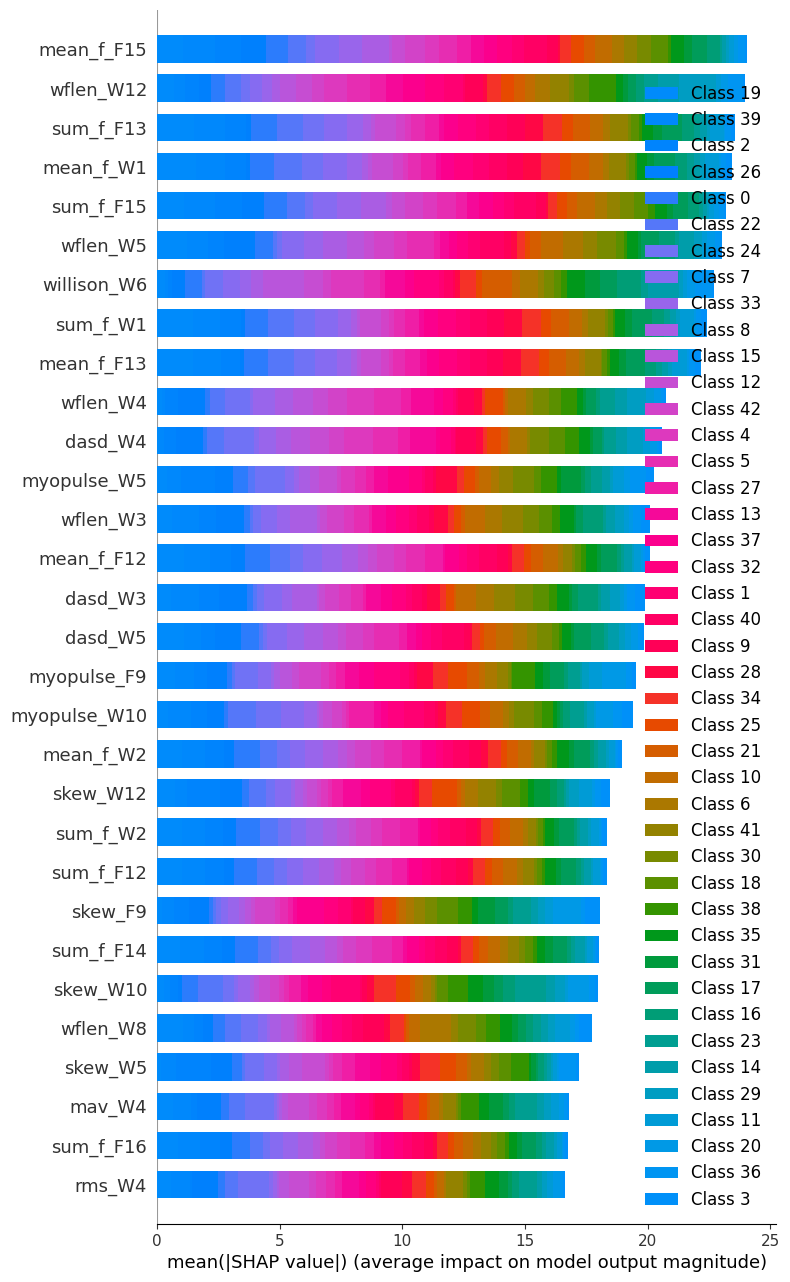

In [66]:
shap.summary_plot(shap_values, feature_names=feature_cols, 
                  max_display=30, 
                  title="Feature importance using Shapley Values (Coloured by class)")

In [127]:
torch.save(model.encoder.state_dict(), 'encoder.pth')

In [68]:
model.encoder.state_dict()

OrderedDict([('l1.weight',
              tensor([[-0.0075,  0.0155,  0.0361,  ..., -0.0012,  0.0248,  0.0646],
                      [-0.0812, -0.0051, -0.0524,  ..., -0.0719, -0.0555, -0.0125],
                      [ 0.0104,  0.0303, -0.0313,  ...,  0.0009, -0.0037, -0.0292],
                      ...,
                      [-0.0233,  0.0555,  0.0622,  ..., -0.0530,  0.1547, -0.1131],
                      [ 0.0298,  0.0334,  0.0212,  ...,  0.0259, -0.0399, -0.1386],
                      [ 0.0230, -0.0197, -0.0922,  ..., -0.0775,  0.0638,  0.0503]])),
             ('l1.bias',
              tensor([-0.0686,  0.1207,  0.0334,  0.0512,  0.0908,  0.0295,  0.0675,  0.0705,
                       0.0784,  0.1629,  0.1034,  0.0654,  0.1666,  0.0505,  0.1005,  0.0324,
                       0.1358,  0.0792,  0.1829,  0.1161,  0.1100,  0.0583,  0.0465,  0.1846,
                       0.0842,  0.0699,  0.1234,  0.1097,  0.0829,  0.1122,  0.1171,  0.0501,
                       0.1615,  0.1195

In [70]:
dump(scaler, open('scaler.pkl', 'wb'))

## Decision Tree (XGBoost)

In [71]:
import xgboost as xgb
from xgboost import XGBClassifier
import time

In [72]:
cls = XGBClassifier(n_jobs = 6)

In [73]:
start = time.time()
cls.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], early_stopping_rounds=10, verbose=True)
print(f"Time taken:  {time.time() - start}  ")

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[0]	validation_0-mlogloss:2.08448	validation_1-mlogloss:2.52747
[1]	validation_0-mlogloss:1.59511	validation_1-mlogloss:2.20645
[2]	validation_0-mlogloss:1.25848	validation_1-mlogloss:1.98513
[3]	validation_0-mlogloss:1.01528	validation_1-mlogloss:1.81619
[4]	validation_0-mlogloss:0.82727	validation_1-mlogloss:1.67684
[5]	validation_0-mlogloss:0.67859	validation_1-mlogloss:1.56344
[6]	validation_0-mlogloss:0.56173	validation_1-mlogloss:1.46821
[7]	validation_0-mlogloss:0.47080	validation_1-mlogloss:1.38637
[8]	validation_0-mlogloss:0.39462	validation_1-mlogloss:1.31147
[9]	validation_0-mlogloss:0.33133	validation_1-mlogloss:1.24619
[10]	validation_0-mlogloss:0.28074	validation_1-mlogloss:1.19117
[11]	validation_0-mlogloss:0.23781	validation_1-mlogloss:1.13737
[12]	validation_0-mlogloss:0.20234	validation_1-mlogloss:1.09091
[13]	validation_0-mlogloss:0.17292	validation_1-mlogloss:1.04775
[14]	validation_0-mlogloss:0.14897	validation_1-mlogloss:1.01147
[15]	validation_0-mlogloss:0.12775	

In [74]:
y_pred = cls.predict(x_test)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.79      0.89      0.83        62
           1       0.75      0.83      0.79        66
           2       0.90      0.94      0.92        70
           3       0.83      0.76      0.79        71
           4       0.86      0.87      0.86        62
           5       0.92      0.90      0.91        84
           6       0.83      0.90      0.86        71
           7       0.86      0.93      0.89        67
           8       0.89      0.83      0.86        78
           9       0.89      0.86      0.88        74
          10       0.83      0.79      0.81        75
          11       0.86      0.91      0.89        89
          12       0.93      0.81      0.87        81
          13       0.80      0.87      0.83        68
          14       0.80      0.82      0.81        72
          15       0.88      0.78      0.83        74
          16       0.88      0.91      0.90        66
          17       0.89    

In [75]:
fi_df = pd.DataFrame({ "name": feature_cols, "values": cls.feature_importances_ } )

In [76]:
sorted_f1_df = fi_df.sort_values(by = "values", ascending=False)

Text(0.5, 1.0, 'Feature Imprtance in XGBoost')

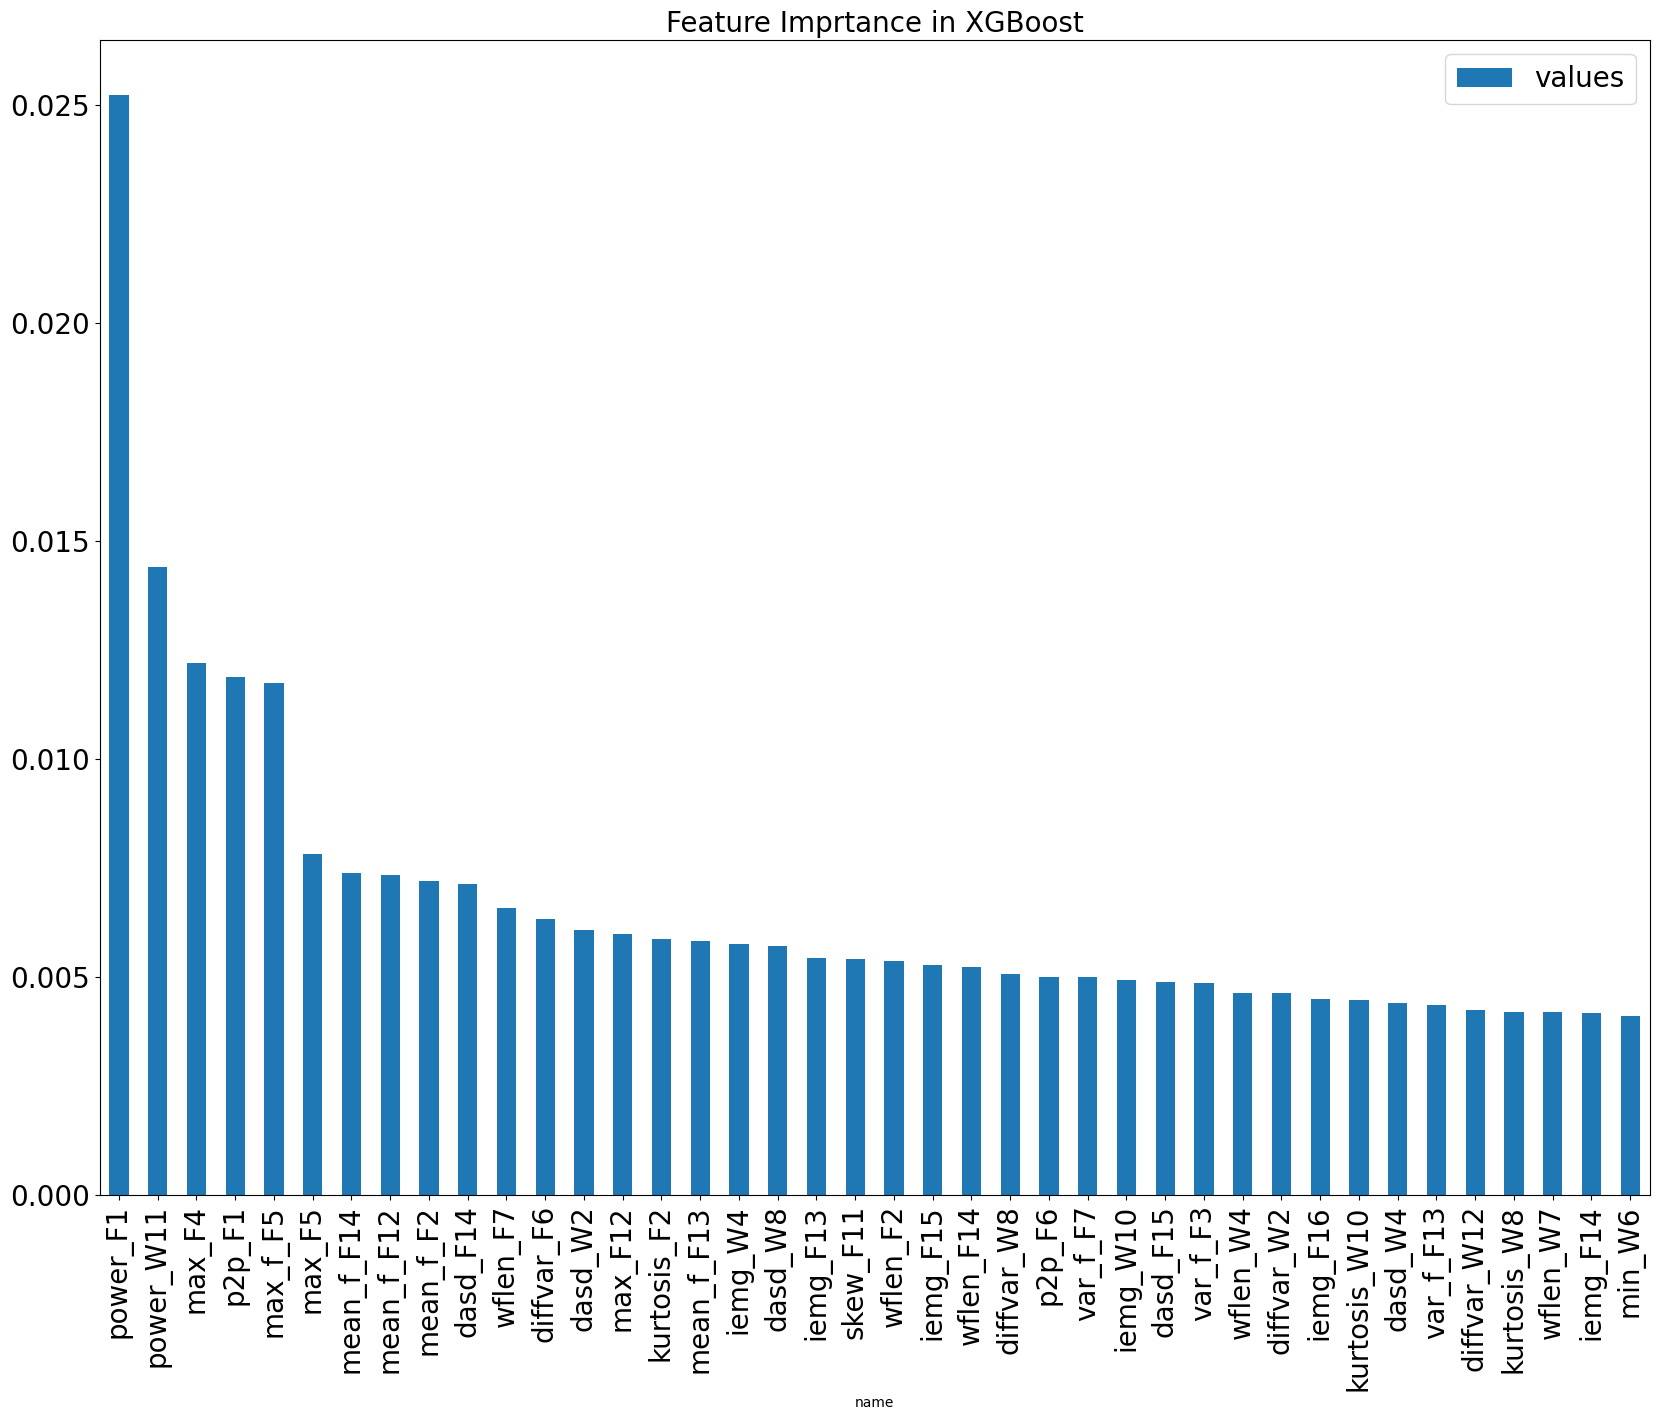

In [77]:

fi_df.sort_values(by = "values", ascending=False)[:40].plot.bar(x = "name", y = "values", figsize = (20,15))
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Feature Imprtance in XGBoost", fontsize=20)

## Split on participants

In [220]:
train_parts = list(range(1,39))

In [265]:
sub_data = data[data['participant'].isin(train_parts)]

In [266]:
X = sub_data.loc[:, feature_cols].values
Y = (sub_data.loc[:, 'participant']-1).values

In [223]:
sub_data

,session,trial,filename,crest_factor_F1,dasd_F1,diffvar_F1,form_factor_F1,iemg_F1,kurtosis_F1,kurtosis_f_F1,...,rms_W9,skew_W9,skew_f_W9,ssi_W9,sum_f_W9,var_f_W9,wflen_W9,willison_W9,gesture,participant
0,1,1,E:\DS5500-project\data\gesture-recognition-and...,7.091099,0.021834,0.000606,-6502.754507,365.456658,2.574033,85.547962,...,0.022588,-0.148877,5.529415,5.224663,0.109574,2.901826e-10,69.944068,15.0,10,1
1,1,2,E:\DS5500-project\data\gesture-recognition-and...,11.178490,0.023852,0.000689,1352.897349,379.664639,16.942218,329.114870,...,0.016172,-0.205427,9.332349,2.677940,0.077566,2.769772e-10,54.530919,23.0,10,1
2,1,3,E:\DS5500-project\data\gesture-recognition-and...,8.047954,0.016213,0.000326,1295.052394,296.823135,3.795827,134.751765,...,0.017039,-0.204604,9.078430,2.973002,0.064458,1.426359e-10,57.815909,13.0,10,1
3,1,4,E:\DS5500-project\data\gesture-recognition-and...,8.459555,0.026572,0.000864,14453.068135,479.688214,6.938354,98.832790,...,0.031982,-0.266818,5.067522,10.473811,0.131909,4.509337e-10,83.441138,0.0,10,1
4,1,5,E:\DS5500-project\data\gesture-recognition-and...,8.329011,0.026896,0.000901,11827.310277,464.350257,2.379207,116.412205,...,0.031134,-0.092205,5.414199,9.925787,0.177516,9.577100e-10,94.393506,3.0,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15346,3,3,E:\DS5500-project\data\gesture-recognition-and...,7.771453,0.013208,0.000208,2599.892725,274.024844,2.176596,28.888640,...,0.020526,-0.293608,3.830298,4.314177,0.035283,1.966555e-11,40.970398,2.0,9,9
15347,3,4,E:\DS5500-project\data\gesture-recognition-and...,9.172642,0.019135,0.000429,1255.242161,385.695263,4.615531,133.237150,...,0.025825,-0.389927,4.200155,6.829604,0.076162,1.003953e-10,52.342457,0.0,9,9
15348,3,5,E:\DS5500-project\data\gesture-recognition-and...,5.923115,0.018533,0.000408,1713.228290,389.039490,1.912226,22.613382,...,0.027460,-0.321020,4.375813,7.721463,0.081006,1.125954e-10,59.843660,0.0,9,9
15349,3,6,E:\DS5500-project\data\gesture-recognition-and...,6.466362,0.015749,0.000292,-992.810528,319.503197,2.189195,21.864578,...,0.013359,-0.493375,3.832319,1.827333,0.062739,6.332731e-11,35.905471,0.0,9,9


In [253]:
scaler = StandardScaler()

In [267]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=25555)

In [268]:
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test) 

In [269]:
model = UserClassifier(x_train.shape[1], 16, len(np.unique(Y)))

In [270]:
model

UserClassifier(
  (encoder): Encoder(
    (l1): Linear(in_features=756, out_features=128, bias=True)
    (l2): Linear(in_features=128, out_features=128, bias=True)
    (l3): Linear(in_features=128, out_features=128, bias=True)
    (l4): Linear(in_features=128, out_features=16, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
    (relu): ReLU()
  )
  (decoder): ClassificationHead(
    (l1): Linear(in_features=16, out_features=64, bias=True)
    (l2): Linear(in_features=64, out_features=38, bias=True)
    (relu): ReLU()
  )
)

In [271]:
model.encoder.state_dict

<bound method Module.state_dict of Encoder(
  (l1): Linear(in_features=756, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=128, bias=True)
  (l3): Linear(in_features=128, out_features=128, bias=True)
  (l4): Linear(in_features=128, out_features=16, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
)>

In [272]:
train_dataset = TensorDataset(torch.tensor(x_train).type(torch.float32), torch.tensor(y_train).type(torch.LongTensor))
test_dataset = TensorDataset(torch.tensor(x_test).type(torch.float32), torch.tensor(y_test).type(torch.LongTensor))

In [273]:
# Define batch size and whether to shuffle the data
batch_size = 256
shuffle = True

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [274]:
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-3)

In [275]:
num_epochs = 100

In [276]:
# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Validation phase
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate and log metrics
    train_loss = total_train_loss / len(train_loader)
    val_loss = total_val_loss / len(test_loader)
    val_accuracy = 100 * correct / total

    if (epoch+1)%10==0:
        print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Epoch [10/100] - Train Loss: 1.7829, Val Loss: 1.5756, Val Accuracy: 53.94%
Epoch [20/100] - Train Loss: 1.1772, Val Loss: 0.9839, Val Accuracy: 72.37%
Epoch [30/100] - Train Loss: 0.8713, Val Loss: 0.7194, Val Accuracy: 80.25%
Epoch [40/100] - Train Loss: 0.7064, Val Loss: 0.5937, Val Accuracy: 83.64%
Epoch [50/100] - Train Loss: 0.5873, Val Loss: 0.5166, Val Accuracy: 85.85%
Epoch [60/100] - Train Loss: 0.5164, Val Loss: 0.4595, Val Accuracy: 88.14%
Epoch [70/100] - Train Loss: 0.4339, Val Loss: 0.4608, Val Accuracy: 87.69%
Epoch [80/100] - Train Loss: 0.4008, Val Loss: 0.3943, Val Accuracy: 89.02%
Epoch [90/100] - Train Loss: 0.3590, Val Loss: 0.3962, Val Accuracy: 89.76%
Epoch [100/100] - Train Loss: 0.3506, Val Loss: 0.3760, Val Accuracy: 91.45%


In [249]:
dump(scaler, open('sub_scaler.pkl', 'wb'))

In [250]:
torch.save(model.encoder.state_dict(), 'sub_encoder.pth')

In [36]:
x_test[x_test>5]

array([6.13882446, 5.48569839, 7.94705767, ..., 6.95335811, 5.8303089 ,
       5.8303089 ])